In [117]:
%matplotlib ipympl
import time
import traceback
from onix.data_tools import get_experiment_data, open_analysis_folder, get_analysis_file_path
from functools import partial
from onix.analysis.fitter import Fitter
from onix.analysis.helper import group_and_average_data
import numpy as np
from matplotlib import colormaps
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import voigt_profile
import allantools
from tqdm import tqdm
from uncertainties import ufloat, unumpy
from scipy.stats import pearsonr
from allantools import adev

In [121]:
def get_average_heights(data_number):
    data, headers = get_experiment_data(data_number)

    detunings_MHz = headers["detunings"].to("MHz").magnitude
    transmissions_avg = group_and_average_data(data["transmissions_avg"], headers["params"]["detect"]["cycles"])
    monitors_avg = group_and_average_data(data["monitors_avg"], headers["params"]["detect"]["cycles"])
    
    plt_monitor = True
    use_positive = None
    
    antihole_avg = transmissions_avg["antihole"]
    rf_avg = transmissions_avg["rf"]
    if "chasm" in transmissions_avg:
        chasm_avg = transmissions_avg["chasm"]
        antihole_normalized = antihole_avg / chasm_avg
        rf_normalized = rf_avg / chasm_avg
    else:
        chasm_avg = None
        antihole_normalized = antihole_avg / monitors_avg["antihole"]
        rf_normalized = rf_avg / monitors_avg["rf"]
    if "lf" in transmissions_avg:
        lf_normalized = transmissions_avg["lf"] / monitors_avg["lf"]
    
    if headers["params"]["field_plate"]["use"]:
        hat_E = headers["params"]["field_plate"]["amplitude"] > 0
        hat_probe = headers["params"]["field_plate"]["stark_shift"] > 0
        mask = detunings_MHz > 0
        mask1 = detunings_MHz < 0
        if "lf" in transmissions_avg:
            return (np.array([np.average(antihole_normalized[mask]), np.average(antihole_normalized[mask1])]), 
            np.array([np.average(rf_normalized[mask]), np.average(rf_normalized[mask1])]), 
            np.array([np.average(lf_normalized[mask]), np.average(lf_normalized[mask1])]), headers, (hat_E, hat_probe))
        else:
            return np.array([
                np.average(antihole_normalized[mask]), np.average(antihole_normalized[mask1])
            ]), np.array([np.average(rf_normalized[mask]), np.average(rf_normalized[mask1])]), headers, (hat_E, hat_probe)
            
    else:
        return np.average(antihole_normalized), np.average(rf_normalized), headers, None

def get_voltage_ratios(data_list):
    ratios = []
    ratios2 = []
    headers = []
    E_fields = []
    # for kk in data_list:
    #     h1, h2, h3, header, E_field = get_average_heights(kk)
    #     ratios.append(h2 / h1)
    #     ratios2.append((h3-h2)/(h2-h1))
    #     headers.append(header)
    #     E_fields.append(E_field)
    # return np.array(ratios), np.array(ratios2), headers, E_fields
    for kk in data_list:
        h1, h2, header, E_field = get_average_heights(kk)
        ratios.append(h2 / h1)
        headers.append(header)
        E_fields.append(E_field)
    return np.ones(len(ratios)), np.array(ratios), headers, E_fields

In [122]:
def averaged_data_from_number(data_number):
    data, headers = get_experiment_data(data_number)
    transmissions_avg = group_and_average_data(data["transmissions_avg"], headers["params"]["detect"]["cycles"])
    monitors_avg = group_and_average_data(data["monitors_avg"], headers["params"]["detect"]["cycles"])
    return (transmissions_avg, monitors_avg, headers)

In [123]:
def data_identification_to_list(data_identification):
    if isinstance(data_identification, tuple):
        return range(data_identification[0], data_identification[1] + 1)
    elif isinstance(data_identification, int):
        return [data_identification]
    else:
        # it should be a list
        return data_identification

## LF Spectroscopy on b, bbar Transition

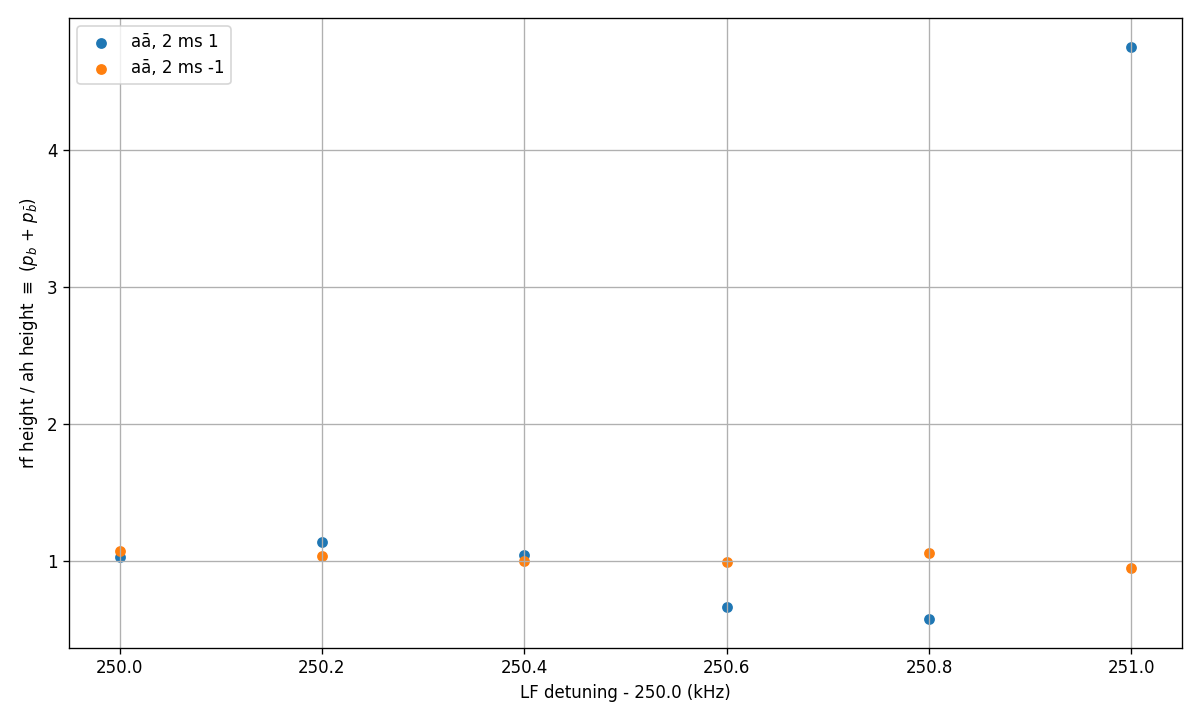

In [399]:
data = {
    "lf scan": (328888, 328927), # heating is an issue, nothing shows
    "lf scan, 1": (328928, 328967), # repeat of above
    "manual": (329029, 329066), # switch AWG for function generator
    "manual, 1": (329069, 329108), #repeat of above
    #"lf off": (329266,329384), # no lf, shows background due to heating
    #"lf scan, 2": (329385,329464) # same as first two
    #"lf scan with delays": (329817, 329896), # step size 0.5 kHz, 1 s delay between steps
    "lf scan with delay": (329897, 330056), # step size 0.25 kHz, 1 s delay between steps
    "lf scan prepare bbar": (330097, 330256)
}
data = {
    "rf test 0.3 ms, rf sweep off": (529783, 529812),
    "rf test 0.2 ms, rf sweep off": (529813, 529828),
    "rf test 0.5 ms, rf sweep off": (529829, 529839),
    "rf test 0.5 ms, rf sweep off, longer antihole": (529858, 529867),
    "rf test 0.5 ms, rf sweep off, antihole rf assist": (529871, 529900),
    "rf test 0.5 ms, rf sweep -110 to -10, antihole rf assist": (529901, 529930),
    "rf test 0.5 ms, rf sweep -110 to -10, antihole rf assist, repeat": (529946, 529975),
    "rf test 0.5 ms, rf sweep -80 to -40, antihole rf assist": (529976, 529990),
}
data = {
    #"lf test, 8000 amplitude, 30 ms": (530006, 530045),
    # "lf test, 8000 amplitude, 30 ms, broader": (530046, 530065),
    # "lf test, 2000 amplitude, 30 ms": (530066, 530085),
    # "lf test, 500 amplitude, 30 ms": (530086, 530105),
    # "lf test, 500 amplitude, 1 ms": (530106, 530125),
    # "lf test, 0 amplitude, 1 ms": (530126, 530145),
    #"lf test, 2000 amplitude, 0.1 ms": (530146, 530165),
    # "bƀ, 1000 amplitude, 0.1 ms": (530166, 530185),
    # "lf test, 1000 amplitude, 0.1 ms, repeat": (531319, 531338),
    #"lf test, 250 amplitude, 0.4 ms": (531339, 531405),
    #"lf test, 100 amplitude, 1 ms": (531406, 531472),
    #"lf test, 200 amplitude, 0.5 ms": (531473, 531539),
    #"lf test, 250 amplitude, 0.4 ms, after fridge stabilization": (531540, 531559),
    #"lf test, 150 amplitude, 0.4 ms": (531560, 531579),
    #"lf test, 125 amplitude, 0.4 ms": (531580, 531619),
    #"lf test, 125 amplitude, 0.4 ms sech": (531620, 531659),
    # "lf test, 125 amplitude, 0.4 ms sech, HSH": (531660, 531699),
    #"lf test, 50 amplitude, 0.4 ms sech, HSH": (531700, 531739),
    #"lf test, 90 amplitude, 0.7 ms sech, HSH": (531740, 531779),

    # "b lf test after code change -- start in b": (531948, 531967),
    # "a, 4000 amplitude, 305 kHz, 0.1 ms": (531968, 531987),
    # "aā, 4000 amplitude, 0.4 ms": (532098, 532111),
    # "aā, 2000 amplitude, 0.8 ms": (532112, 532131),

    # "bƀ, 30 amplitude, 2 ms": (532267, 532306),
    # "bƀ, 120 amplitude, 0.5 ms": (532307, 532316),
    # "bƀ, 60 amplitude, 1 ms": (532317, 532326),
    # "bƀ, 30 amplitude, 2 ms": (532327, 532336),

    
    # "bƀ, 60 amplitude, 1 ms - dense": (532338, 532367),
    # "bƀ, 60 amplitude, 1 ms - dense - again": (532368, 532397),
    # "bƀ, 60 amplitude, 1 ms - dense - flip": (532398, 532427),
    
    # "aā, 800 amplitude, 1 ms - dense": (532428, 532457),
    # "aā, 800 amplitude, 1 ms - dense - again": (532458, 532487),
    # "aā, 800 amplitude, 1 ms - dense - flip": (532488, 532517),
    
    # "aā, 800 amplitude - 1 ms": (532428, 532487),
    # "bƀ, 60 amplitude - 1 ms": (532338, 532427)

    # "test 12": (534351, 534362),
    # "test 13": (534363, 534374),

    ## DENSE
    # "bƀ, 60 amplitude - 1 ms 1": (535187, 535486),
    # "bƀ, 60 amplitude - 1 ms 2": (535487, 535786),
    # "bƀ, 60 amplitude - 1 ms 3": (535787, 536086),
    # "bƀ, 60 amplitude - 1 ms 4": (536087, 536386),
    # "bƀ, 60 amplitude - 1 ms 5": (536387, 536686),

    # "bƀ": (535487, 538486),

    "aā, 2 ms": (845221, 845227),
}

# def averaging_ys(xs, ys):
#     xs_unique = np.unique(xs)
#     ys_to_avg = [[] for _ in range(len(xs_unique))]
#     for x, y in zip(xs, ys):
#         ys_to_avg[np.argwhere(xs_unique == x)[0][0]].append(y)
#     ys_avg = []
#     for y_list in ys_to_avg:
#         ys_avg.append(np.average(y_list))
#     ys_avg = np.array(ys_avg)
    
#     return xs_unique, ys_avg
    

def averaging_ys(xs, ys):
    xs_unique = np.unique(xs)
    ys_to_avg = [[] for _ in range(len(xs_unique))]
    for x, y in zip(xs, ys):
        ys_to_avg[np.argwhere(xs_unique == x)[0][0]].append(y)
    ys_avg = []
    ys_std = []
    for y_list in ys_to_avg:
        ys_avg.append(np.average(y_list))
        ys_std.append(np.std(y_list))
    ys_avg = np.array(ys_avg)
    ys_std = np.array(ys_std)
    
    return xs_unique, ys_avg, ys_std
    

fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    rf_heights, ah_heights, rf_bgs, ah_bgs, headers = rf_spectroscopy_ah_ratio(data_list)
    for kk in rf_heights:
        xs = [header["params"]["lf"]["center_frequency"].to("kHz").magnitude for header in headers]    
        ys = rf_heights[kk] / ah_heights[kk]
        ax.scatter(xs, ys, label=label + f" {kk}", s = 30)
        xs, ys, errs = averaging_ys(xs, ys)
        # ax.errorbar(xs, ys, errs, label=label, marker='.', linestyle='')

ax.set_xlabel(f"LF detuning - {headers[0]["params"]["lf"]["center_frequency"].to("kHz").magnitude} (kHz)")
ax.set_ylabel("rf height / ah height $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

Fitting error for data number #845196:


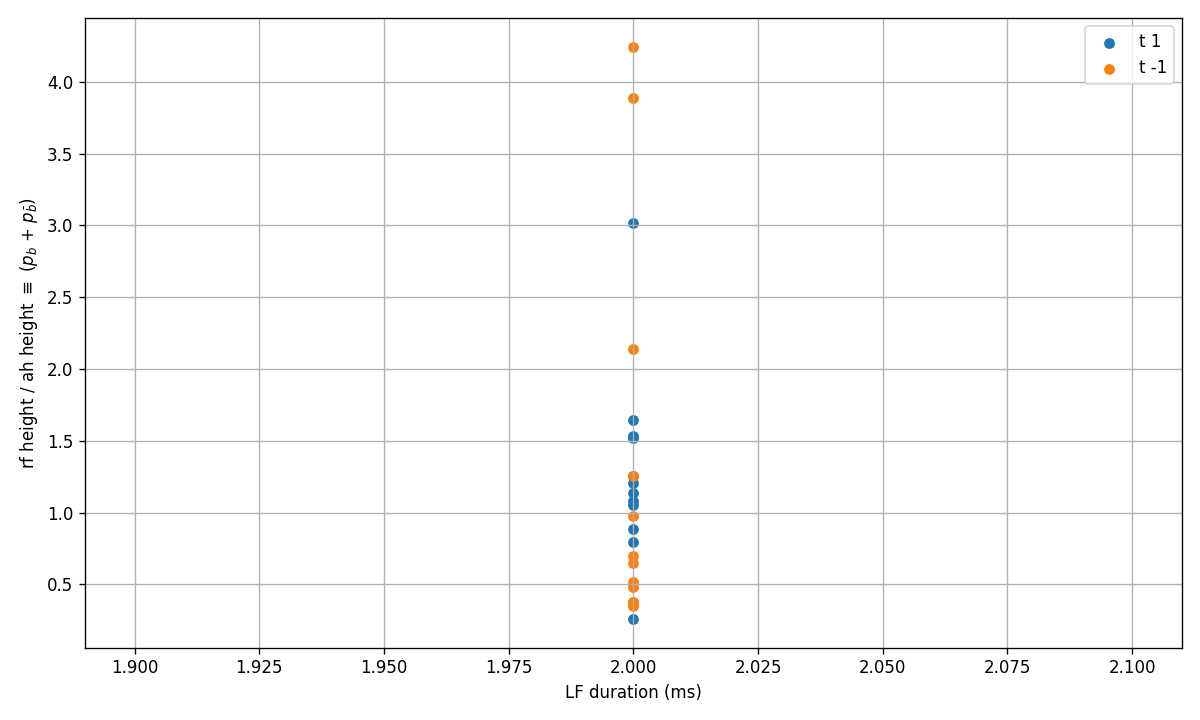

In [387]:
data = {
    # "lf 1000 amplitude": (530186, 530205),
    # "lf 8000 amplitude": (530226, 530245),
    # "b lf 8000 amplitude, shorter": (530266, 530285),
    # "lf 8000 amplitude, 1": (530396, 530396 + 922 - 1),

    # "aabar lf 4000 amplitude, 302 kHz": (531988, 532007),
    # "a lf 8000 amplitude, 302 kHz, longer": (532008, 532037),
    # "a lf 8000 amplitude, 302 kHz, longer, again": (532038, 532067),
    # "a lf 8000 amplitude, 302 kHz, longer, longer": (532068, 532097),
    
    # "a lf 800 amplitude": (532132, 532161),
    # "a lf 400 amplitude": (532162, 532191),
    # "b lf 40 amplitude": (532207, 532234),
    # "b lf 30 amplitude": (532237, 532266),
    
    # "b lf 6000 amplitude": (532788, 532822),
    "b 6000 amplitude": (533030, 533279),
    "a 6000 amplitude": (533280, 533529),
    # "b 6000 amplitude 2": (533530, 533779),
    # "b 6000 amplitude 3": (533780, 534029),
}
fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    rf_heights, ah_heights, rf_bgs, ah_bgs, headers = rf_spectroscopy_ah_ratio(data_list)
    xs = [header["params"]["lf"]["duration"].to("ms").magnitude for header in headers]
    for kk in rf_heights:
        ys = rf_heights[kk] / ah_heights[kk]
        ax.scatter(xs, ys, label=label + f" {kk}", s = 30)

ax.set_xlabel(f"LF duration (ms)")
ax.set_ylabel("rf height / ah height $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

## LF Spin Echo bbbar

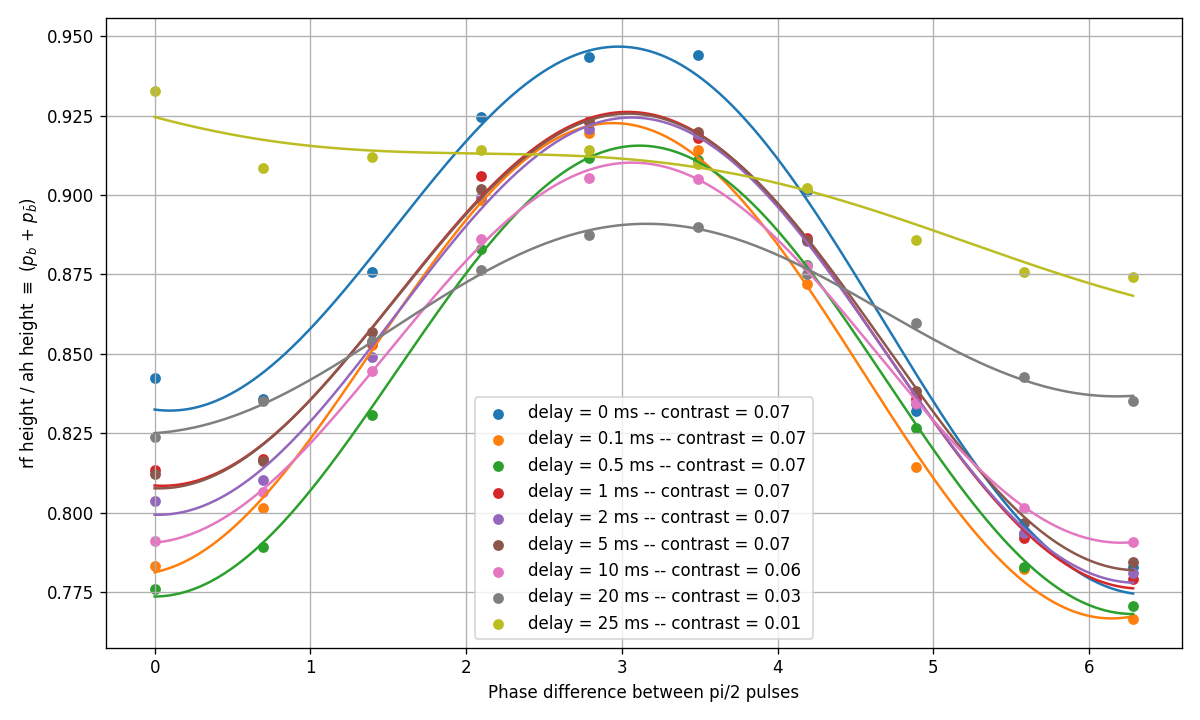

In [330]:
def sine_func(phi, a, theta, b, c) :
    return a * np.sin(phi + theta) + b*phi + c

def sineFit(xs, ys):
    fitter = Fitter(sine_func)
    fitter.set_absolute_sigma(False)
    fitter.set_data(xs, ys)
    fitter.fit(maxfev = 10000)
    return fitter

data = {
    # "6000 amplitude, 0.025 ms pi time, 0 ms delay": (532828, 532837),
    "6000 amplitude, 0.025 ms pi time, 0 ms delay": (532838, 532847),
    "6000 amplitude, 0.025 ms pi time, 0.1 ms delay": (532848, 532857),
    "6000 amplitude, 0.025 ms pi time, 0.5 ms delay": (532858, 532867),
    "6000 amplitude, 0.025 ms pi time, 1 ms delay": (532868, 532877),
    "6000 amplitude, 0.025 ms pi time, 2 ms delay": (532878, 532887),
    "6000 amplitude, 0.025 ms pi time, 5 ms delay": (532888, 532897),
    "6000 amplitude, 0.025 ms pi time, 10 ms delay": (532898, 532907),
    "6000 amplitude, 0.025 ms pi time, 20 ms delay": (532908, 532917),
    "6000 amplitude, 0.025 ms pi time, 25 ms delay": (532918, 532927),
}

contrasts_b = []
delays_b = []
fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    rf_heights, ah_heights, rf_bgs, ah_bgs, headers = rf_spectroscopy_ah_ratio(data_list)
    xs = [header["params"]["lf"]["phase"] for header in headers]
    ys = rf_heights[0] / ah_heights[0]
    
    gaussian_fit = sineFit(xs, ys)
    xs_fit = np.linspace(np.min(xs), np.max(xs), 1000)
    ax.plot(xs_fit, gaussian_fit.fitted_value(xs_fit))

    contrast = abs(gaussian_fit.results["a"])
    delay = headers[0]["params"]["lf"]["delay_time"].to("ms").magnitude
    
    contrasts_b.append(contrast)
    delays_b.append(delay)
    
    ax.scatter(xs, ys, label=f"delay = {delay} ms -- contrast = {contrast:.2f}", s = 30)


ax.set_xlabel(f"Phase difference between pi/2 pulses")
ax.set_ylabel("rf height / ah height $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

## LF Spin Echo aabar

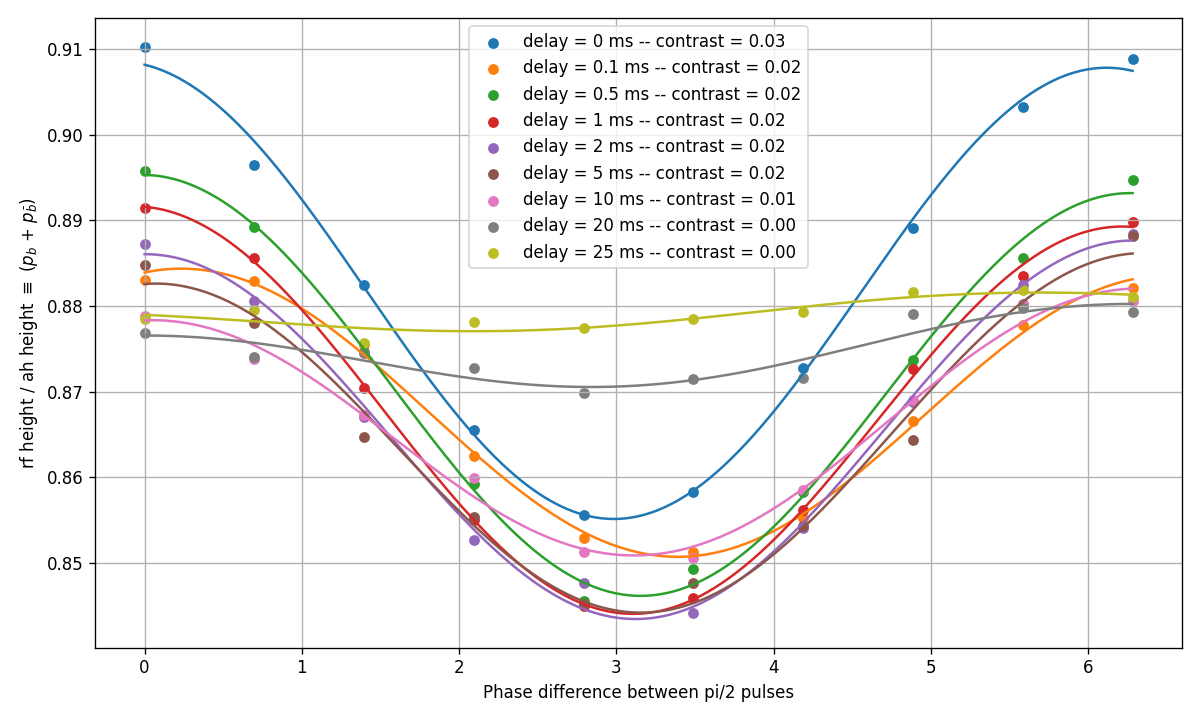

In [331]:
data = {
    # "6000 amplitude, 0.33 ms pi time, 0 ms delay": (532928, 532937),
    "6000 amplitude, 0.33 ms pi time, 0 ms delay": (532938, 532947),
    "6000 amplitude, 0.33 ms pi time, 0.1 ms delay": (532948, 532957),
    "6000 amplitude, 0.33 ms pi time, 0.5 ms delay": (532958, 532967),
    "6000 amplitude, 0.33 ms pi time, 1 ms delay": (532968, 532977),
    "6000 amplitude, 0.33 ms pi time, 2 ms delay": (532978, 532987),
    "6000 amplitude, 0.33 ms pi time, 5 ms delay": (532988, 532997),
    "6000 amplitude, 0.33 ms pi time, 10 ms delay": (532998, 533007),
    "6000 amplitude, 0.33 ms pi time, 20 ms delay": (533008, 533017),
    "6000 amplitude, 0.33 ms pi time, 25 ms delay": (533018, 533027),
}

contrasts_a = []
delays_a = []
fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    rf_heights, ah_heights, rf_bgs, ah_bgs, headers = rf_spectroscopy_ah_ratio(data_list)
    xs = [header["params"]["lf"]["phase"] for header in headers]
    ys = rf_heights[0] / ah_heights[0]
    
    gaussian_fit = sineFit(xs, ys)
    xs_fit = np.linspace(np.min(xs), np.max(xs), 1000)
    ax.plot(xs_fit, gaussian_fit.fitted_value(xs_fit))

    contrast = abs(gaussian_fit.results["a"])
    delay = headers[0]["params"]["lf"]["delay_time"].to("ms").magnitude
    
    contrasts_a.append(contrast)
    delays_a.append(delay)
    
    ax.scatter(xs, ys, label=f"delay = {delay} ms -- contrast = {contrast:.2f}", s = 30)


ax.set_xlabel(f"Phase difference between pi/2 pulses")
ax.set_ylabel("rf height / ah height $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

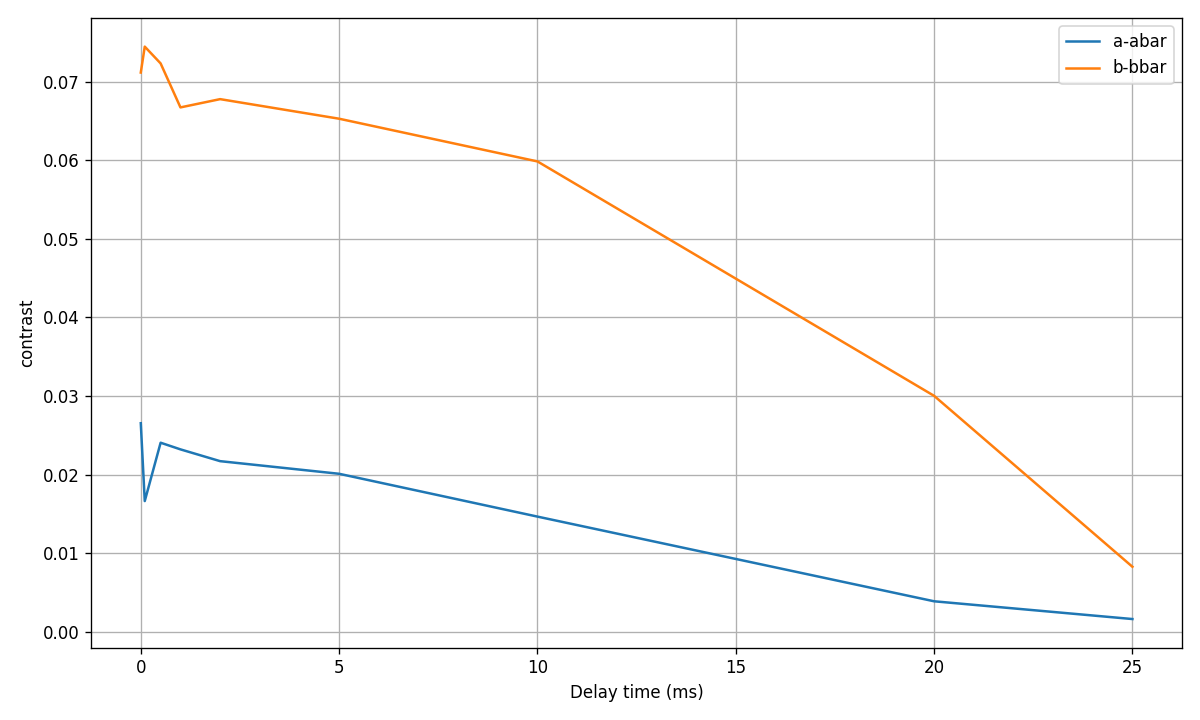

In [333]:
fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
ax.plot(delays_a, contrasts_a, label="a-abar")
ax.plot(delays_b, contrasts_b, label="b-bbar")
ax.set_xlabel(f"Delay time (ms)")
ax.set_ylabel("contrast")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

## Hole and AOM only

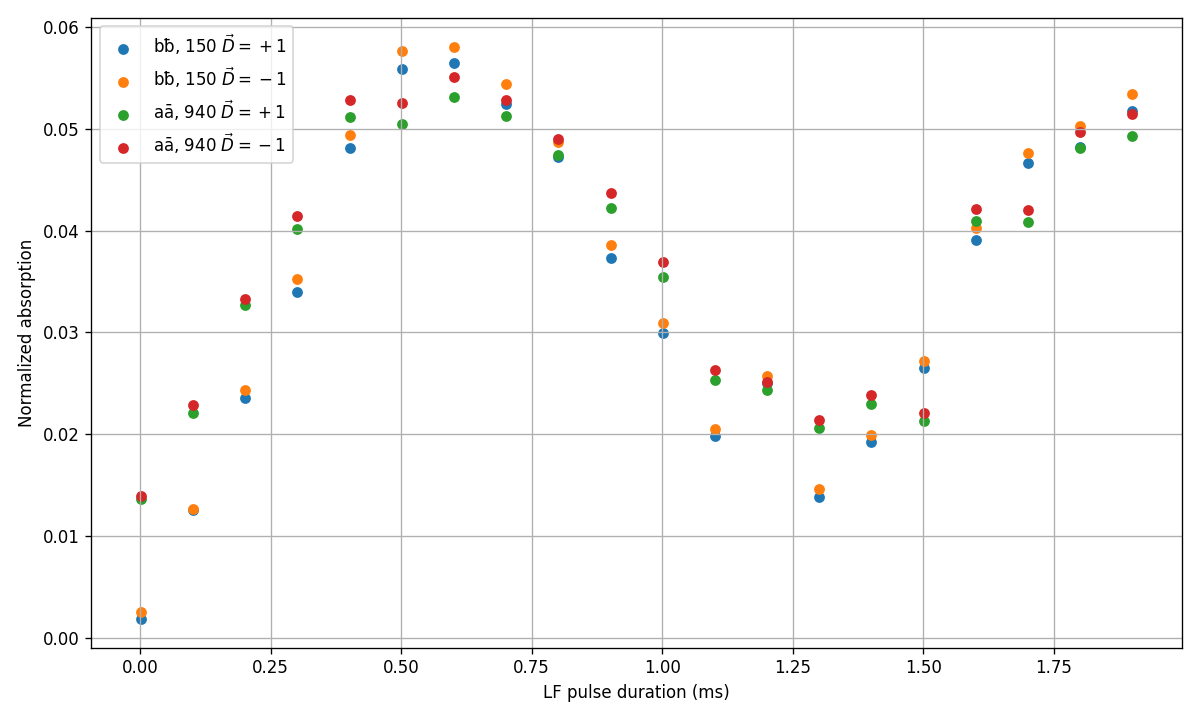

In [327]:
data = {
    # "aā, 8000": (821270, 821329),
    # "bƀ, 580": (822057, 822116),
    # "bƀ, 50": (822341, 822370),
    # "bƀ, 45": (822375, 822454),
    # "aā, 280": (822779, 822858),
    "bƀ, 150": (823375, 823394),
    "aā, 940": (823524, 823543),
}

fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    ratios_bg, ratios, headers, E_field = get_voltage_ratios(data_list)
    xs = [header["params"]["lf"]["duration"].to("ms").magnitude for header in headers]
    ys = (1-ratios)
    if ys.ndim == 2:
        for kk in range(len(ys[0])):
            if E_field[0][0] == (kk == 0):
                label_E = label + " $\\vec{D}=+1$"
            else:
                label_E = label + " $\\vec{D}=-1$"
            ax.scatter(xs, ys[:,kk], label=label_E, s = 30)
    else:
        ax.scatter(xs, ys, label=label_E, s = 30)

ax.set_xlabel(f"LF pulse duration (ms)")
ax.set_ylabel("Normalized absorption")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

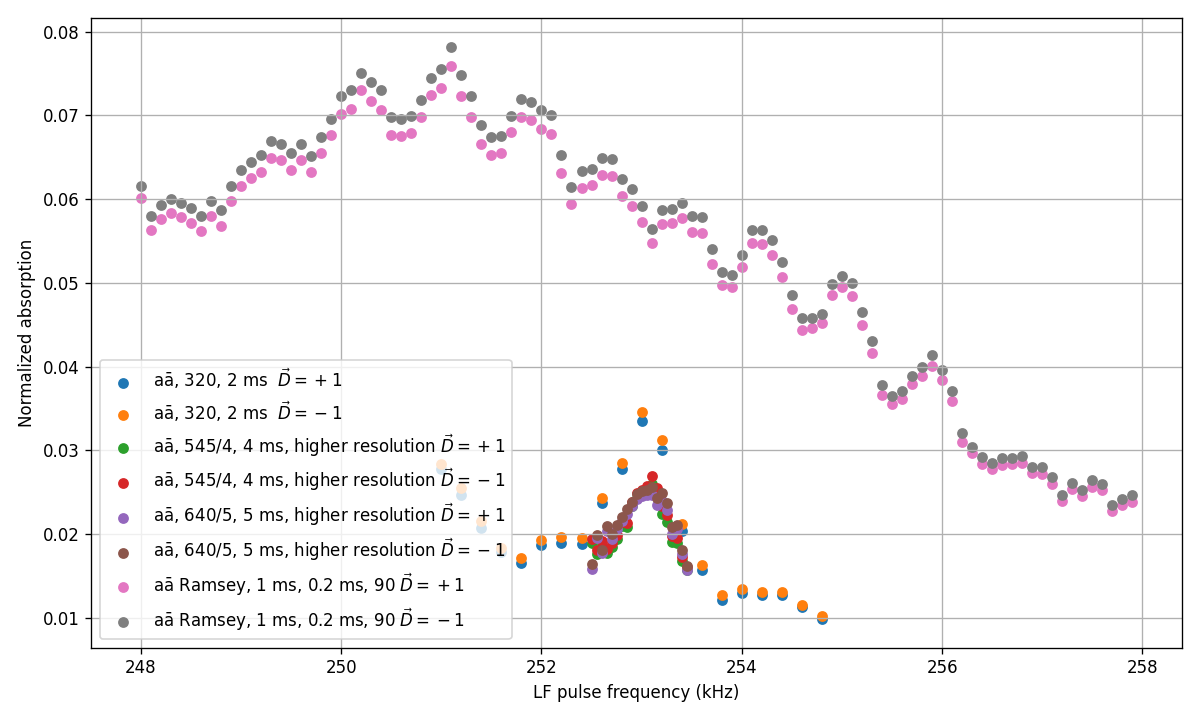

In [545]:
f_average = True

data = {
    # "aa, 6000": (815779, 815803),
    # "aa, 6000, repeat": (815804, 815822),
    # "bƀ, July 7, 1000, 0.1 ms": (817132, 817162),
    # "bƀ, July 7, 200, 1 ms": (817163, 817193),
    # "bƀ, July 7, 500, 0.5 ms": (817194, 817224),
    # "bƀ, July 7, 1000, 0.5 ms": (817225, 817251),
    # "bƀ, July 7, 500, 0.5 ms": (817252, 817278),
    # "bƀ, July 7, 250, 0.5 ms": (817279, 817331),
    # "bƀ, July 7, 125, 0.5 ms": (817332, 817384),
    # "bƀ, July 7, 63, 0.5 ms": (817385, 817437),
    # "bƀ, July 7, 32, 0.5 ms, more averages": (817438, 817473),
    # "bƀ, July 7, 250, 0.5 ms, repeat": (817474, 817526),
    # "bƀ, July 7, 250, 0.5 ms, cb -1 MHz": (817527, 817579),
    # "bƀ, July 7, 250, 0.5 ms, E field on": (817580, 817632),
    # "bƀ, July 7, 250, 0.5 ms, more ah repeats": (817633, 817685),
    # "bƀ, July 7, 125, 2 ms": (817686, 817738),
    #"bƀ, July 7, 63, 2 ms": (817951, 817991),
    #"bƀ, July 7, 63, 2 ms, repeat": (817992, 818032),
    #"bƀ, July 7, 63, 2 ms, all": (817951, 818114),
    # "bƀ, 32, 2 ms": (818115, 818843),
    # "aā, 320, 2 ms": (818925, 821247),
    # "bƀ Ramsey, 25 us, 50 us, 90": (843805, 843966),  # good data
    # "bƀ Ramsey, 25 us, 50 us, -90": (843967, 844128),
    # "bƀ Ramsey, 25 us, 50 us, 90, -E": (844129, 844290),
    # "bƀ Ramsey, 25 us, 50 us, -90, -E": (844291, 844452),
    # "bƀ Ramsey, 250 us, 250 us, 90": (844455, 844555),
    # "bƀ Ramsey, 250 us, 50 us, 90": (844556, 844656),


    ## July 8
    "aā, 320, 2 ms ": (845310, 845445),
    # "aā, 320, 5 ms": (845489, 845951), #wrong amplitude
    # "aā, 109, 5 ms": (846032, 846158),
    # "aā, 545/5, 5 ms, higher resolution": (846159, 846478),

    # "aā, 320, 2 ms again": (846512, 846561),
    # "aā, 320, 2 ms, higher resolution": (846580, 847053),
    "aā, 545/4, 4 ms, higher resolution": (847054, 847513),
    "aā, 640/5, 5 ms, higher resolution": (847519, 847629),

    # "aā Ramsey, 1 ms, 0.2 ms, 0": (847646, 850725),
    "aā Ramsey, 1 ms, 0.2 ms, 90": (850744, 852843),
    # "aā Ramsey, 0.5 ms, 0.1 ms, 0": (859434, 859632),
}

fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    ratios_bg, ratios, headers, E_field = get_voltage_ratios(data_list)
    xs = np.array([(header["params"]["lf"]["detuning"] + header['params']['lf']['center_frequency']).to("kHz").magnitude for header in headers])
    ys = (1-ratios)
    if f_average:
        discrete_xs = list(set(xs))
        new_xs = []
        new_ys = []
        for x in discrete_xs:
            new_xs.append(x)
            mask = xs == x
            new_ys.append(np.average(ys[mask], axis=0))
        xs = np.array(new_xs)
        ys = np.array(new_ys)
    if ys.ndim == 2:
        for kk in range(len(ys[0])):
            if E_field[0][0] == (kk == 0):
                label_E = label + " $\\vec{D}=+1$"
            else:
                label_E = label + " $\\vec{D}=-1$"
                
            ax.scatter(xs, ys[:,kk], label=label_E, s = 30)
    else:
        label = label
        ax.scatter(xs, ys, label=label, s = 30)

ax.set_xlabel(f"LF pulse frequency (kHz)")
ax.set_ylabel("Normalized absorption")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

## Ramsey subtraction

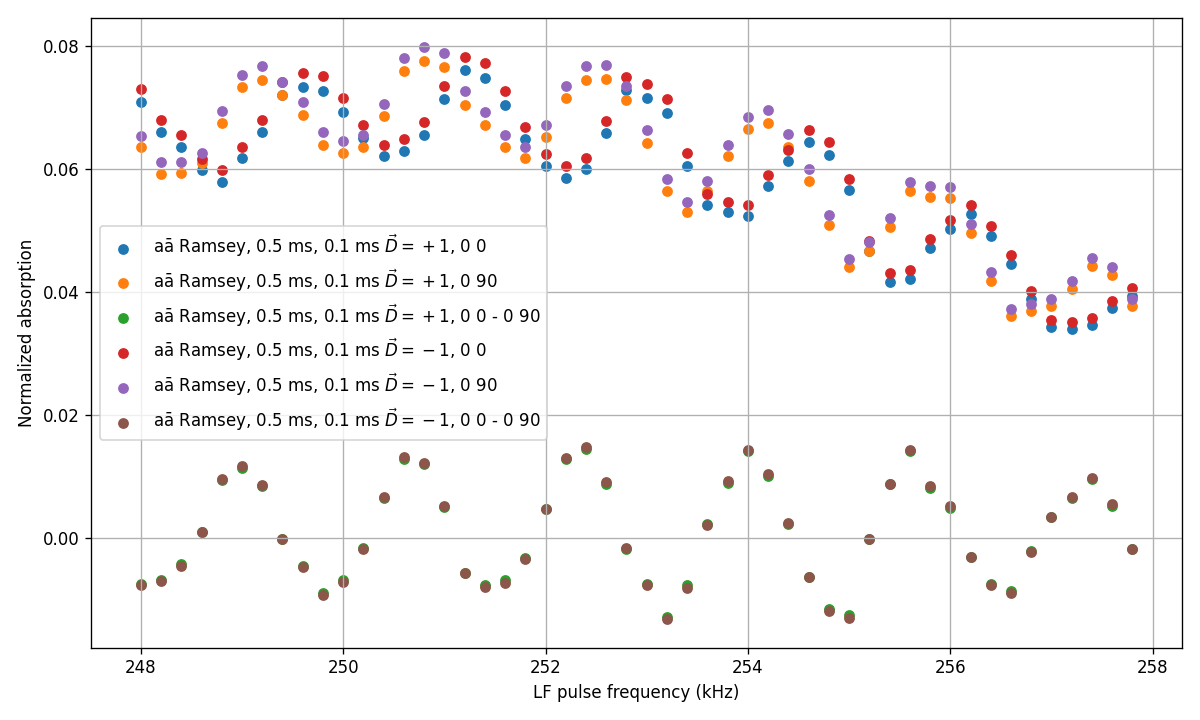

In [546]:
data = {
    # "aā Ramsey, 1 ms, 0.2 ms": (856020, 859303),
    "aā Ramsey, 0.5 ms, 0.1 ms": (859634, 861389),
}

def averaging_ys(xs, ys):
    discrete_xs = list(set(xs))
    new_xs = []
    new_ys = []
    for x in discrete_xs:
        new_xs.append(x)
        mask = xs == x
        new_ys.append(np.average(ys[mask], axis=0))
    xs = np.array(new_xs)
    ys = np.array(new_ys)
    return xs, ys
    
fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    ratios_bg, ratios, headers, E_field = get_voltage_ratios(data_list)
    xs = np.array([(header["params"]["lf"]["detuning"] + header['params']['lf']['center_frequency']).to("kHz").magnitude for header in headers])
    ys = (1-ratios)
    
    ys_0 = []
    xs_0 = []
    ys_90 = []
    xs_90 = []
    
    for kk, y in enumerate(ys):
        if headers[kk]["params"]["lf"]["phase_diff"] == 0:
            ys_0.append(y)
            xs_0.append(xs[kk])
        else:
            ys_90.append(y)
            xs_90.append(xs[kk])
            
    ys_0 = np.array(ys_0)
    xs_0 = np.array(xs_0)
    ys_90 = np.array(ys_90)
    xs_90 = np.array(xs_90)
    
    xs_0, ys_0 = averaging_ys(xs_0, ys_0)
    xs_90, ys_90 = averaging_ys(xs_90, ys_90)
    
    ys_diff = ys_90 - ys_0

    if ys_diff.ndim == 2:
        for kk in range(len(ys[0])):
            if E_field[0][0] == (kk == 0):
                label_E = label + " $\\vec{D}=+1$"
            else:
                label_E = label + " $\\vec{D}=-1$"
            ax.scatter(xs_0, ys_0[:,kk], label=label_E+", 0 0", s = 30)
            ax.scatter(xs_90, ys_90[:,kk], label=label_E+", 0 90", s = 30)
            ax.scatter(xs_0, ys_diff[:,kk], label=label_E+", 0 0 - 0 90", s = 30)
    else:
        label = label
        ax.scatter(xs, ys_diff, label=label, s = 30)

ax.set_xlabel(f"LF pulse frequency (kHz)")
ax.set_ylabel("Normalized absorption")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

## Time-series

In [33]:
def get_lorentzian_fit(detunings, voltages, p0=None, bounds=None):
    def lorentzian(f, f_0, gamma, a, c):
        return (gamma / 2) / ((f - f_0) ** 2 + gamma ** 2 / 4) * a + c
    fitter = Fitter(lorentzian)
    fitter.set_absolute_sigma(False)
    fitter.set_data(detunings, voltages)
    fitter.set_p0({"f_0": 0.001, "c": 0.001, "gamma": 1, "a": 1})
    if p0 is not None:
        fitter.set_p0(p0)
    if bounds is not None:
        for bound_var, bound in bounds.items():
            fitter.set_bounds(bound_var, bound[0], bound[1])
    fitter.fit(maxfev = 10000)
    return fitter

ValueError: too many values to unpack (expected 3)

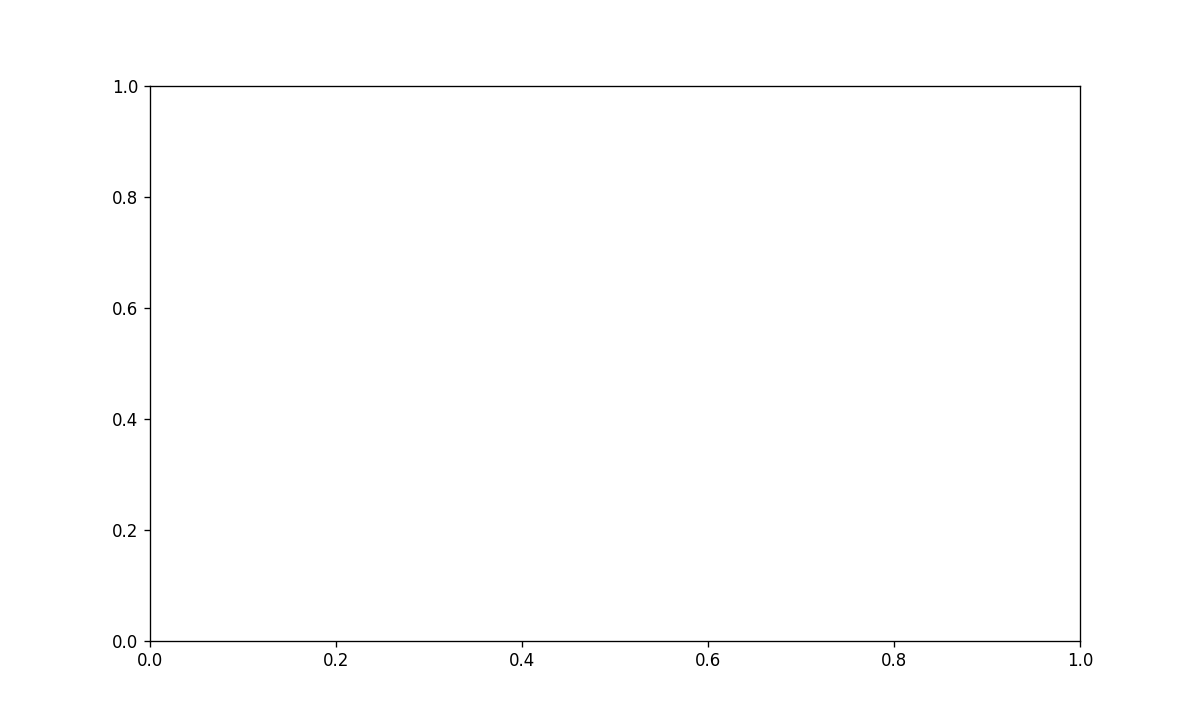

In [393]:
data = {
    "b-bbar, 0.2 ms, 300, 1": (553422, 553442),  # original parameters
    # "b-bbar, 0.2 ms, 300, 2": (553443, 553463),
    # "b-bbar, 0.2 ms, 300, 3": (553464, 553484),
    # "b-bbar, 0.2 ms, 300, 4": (553485, 553505),
    # "b-bbar, 0.2 ms, 300, 1": (553506, 553526),  # negative Stark shift
    # "b-bbar, 0.2 ms, 300, 2": (553527, 553547),
    # "b-bbar, 0.2 ms, 300, 3": (553548, 553568),
    # "b-bbar, 0.2 ms, 300, 1": (553578, 553598),  # 5x longer chasms
    # "b-bbar, 0.2 ms, 300, 2": (553599, 553619),
    # "b-bbar, 0.2 ms, 300, 3": (553620, 553640),
    # "b-bbar, 0.2 ms, 300, 4": (553641, 553661),
    # "b-bbar, 0.2 ms, 300, 1": (553665, 553685),  # RF sweep 3x longer, this seems to eliminate the offset
    # "b-bbar, 0.2 ms, 300, 2": (553686, 553706),
    # "b-bbar, 0.2 ms, 300, 3": (553707, 553727),
    # "b-bbar, 0.2 ms, 300, 4": (553728, 553748),
    # "b-bbar, 0.2 ms, 300, 5": (553749, 553769),
    # "b-bbar, 0.2 ms, 300, 6": (553770, 553790),
    # "b-bbar, 0.2 ms, 300, 7": (553791, 553811),
    # "b-bbar, 0.2 ms, 300, 8": (553812, 553832),
    # "b-bbar, 0.2 ms, 300, 1": (553833, 553853),  # back to the original params
    # "b-bbar, 0.2 ms, 300, 2": (553854, 553874),
    # "b-bbar, 0.2 ms, 300, 3": (553875, 553895),
    # "b-bbar, 0.2 ms, 300, 4": (553896, 553916),
    # "b-bbar, 0.2 ms, 300, 1": (553919, 553939),  # ao center frequency -3 MHz
    # "b-bbar, 0.2 ms, 300, 2": (553940, 553960),
    # "b-bbar, 0.2 ms, 300, 3": (553961, 553981),
    # "b-bbar, 0.2 ms, 300, 4": (553982, 554002),
    # "b-bbar, 0.2 ms, 300, 1": (554006, 554026),  # RF sweep 3x longer again
    # "b-bbar, 0.2 ms, 300, 2": (554027, 554047),
    # "b-bbar, 0.2 ms, 300, 3": (554048, 554068),
    # "b-bbar, 0.2 ms, 300, 4": (554069, 554089),
}

fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    ratios, headers, E_field = get_voltage_ratios(data_list)
    xs = [header["params"]["lf"]["detuning"].to("kHz").magnitude for header in headers]
    ys = (1-ratios)
    if E_field[0] is not None:
        ax.scatter(xs, ys[:,0], label=label + " pos Stark", s = 30)
        pos_fit = get_lorentzian_fit(xs, ys[:,0])
        print(pos_fit.result_str("f_0"), E_field[0][0] == E_field[0][1])
        ax.plot(xs, pos_fit.fitted_value(xs))
        ax.scatter(xs, ys[:,1], label=label + " neg Stark", s = 30)
        neg_fit = get_lorentzian_fit(xs, ys[:,1])
        print(neg_fit.result_str("f_0"), E_field[0][0] != E_field[0][1])
        print()

ax.set_xlabel(f"LF detuning - {headers[0]["params"]["lf"]["center_frequency"].to("kHz").magnitude} (kHz)")
ax.set_ylabel("Normalized absorption")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

In [394]:
data = {
    "b-bbar, 0.2 ms, 300, 1": (539925, 539945),  # 10 ms RF
    "b-bbar, 0.2 ms, 300, 2": (539946, 539966),
    "b-bbar, 0.2 ms, 300, 3": (539967, 539987),
    "b-bbar, 0.2 ms, 300, 4": (539988, 540008),
}
data = {
    "b-bbar, 0.2 ms, 300, 1": (554006, 554026),  # 30 ms RF
    "b-bbar, 0.2 ms, 300, 2": (554027, 554047),
    "b-bbar, 0.2 ms, 300, 3": (554048, 554068),
    "b-bbar, 0.2 ms, 300, 4": (554069, 554089),
}
max = 558500
fs = {}

for kk in data:
    fs[kk] = []

current = data[list(data.keys())[0]][1]
offset = 0
while current + offset <= max:
    for ll, (label, data_range) in enumerate(data.items()):
        data_range = (data_range[0] + offset, data_range[1] + offset)
        data_list = data_identification_to_list(data_range)
        ratios, headers, E_field = get_voltage_ratios(data_list)
        xs = [header["params"]["lf"]["detuning"].to("kHz").magnitude for header in headers]
        ys = (1-ratios)
        if E_field[0] is not None:
            # ax.scatter(xs, ys[:,0], label=label + " pos Stark", s = 30)
            pos_fit = get_lorentzian_fit(xs, ys[:,0])
            #ax.plot(xs, pos_fit.fitted_value(xs))
            #print(pos_fit.all_results_str())
            # ax.scatter(xs, ys[:,1], label=label + " neg Stark", s = 30)
            neg_fit = get_lorentzian_fit(xs, ys[:,1])
            fs[label].append([pos_fit, neg_fit])
    offset += 21 * 4

ValueError: too many values to unpack (expected 3)

In [492]:
f1 = []
f2 = []
for kk in range(len(fs['b-bbar, 0.2 ms, 300, 1'])):
    for label in fs:
        if int(label[-1]) % 2 == 3:
            continue
        if int(label[-1]) <= 2:
            f1.append(ufloat(fs[label][kk][0].results["f_0"], fs[label][kk][0].errors["f_0"]))
            f2.append(ufloat(fs[label][kk][1].results["f_0"], fs[label][kk][1].errors["f_0"]))
        else:
            f1.append(ufloat(fs[label][kk][1].results["f_0"], fs[label][kk][1].errors["f_0"]))
            f2.append(ufloat(fs[label][kk][0].results["f_0"], fs[label][kk][0].errors["f_0"]))
f1 = np.array(f1)
f2 = np.array(f2)

-0.1247877811843141 0.01305001659124386
-0.11287166474074418 0.013454503109024726
0.0007821162333136271


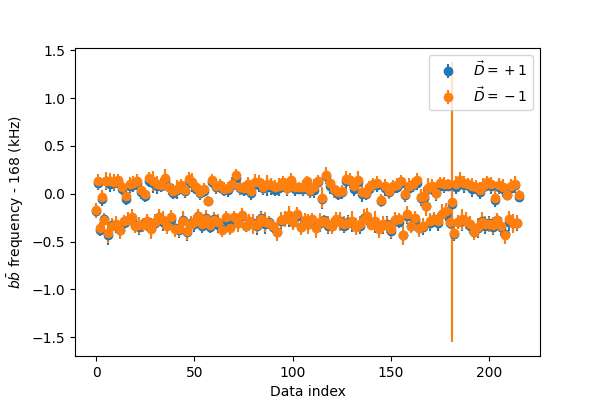

In [493]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.errorbar(np.arange(len(f1)), unumpy.nominal_values(f1), unumpy.std_devs(f1), fmt="o", label="$\\vec{D}=+1$")
print(np.average(unumpy.nominal_values(f1)), np.std(unumpy.nominal_values(f1)) / np.sqrt(len(f1)))
ax.errorbar(np.arange(len(f2)), unumpy.nominal_values(f2), unumpy.std_devs(f2), fmt="o", label="$\\vec{D}=-1$")
print(np.average(unumpy.nominal_values(f2)), np.std(unumpy.nominal_values(f2)) / np.sqrt(len(f2)))
print(np.std(unumpy.nominal_values(f1 - f2)) / np.sqrt(len(f2)))
ax.set_xlabel("Data index")
ax.set_ylabel("$b\\bar{b}$ frequency - 168 (kHz)")
ax.legend()
plt.show()

## Time-series Ramsey

In [9]:
def get_sine_fit(detunings, voltages, p0=None, bounds=None):
    def sine(f, f_0, t, a, c):
        return np.sin(2*np.pi*(f - f_0) * t) * a + c
    fitter = Fitter(sine)
    fitter.set_absolute_sigma(False)
    fitter.set_data(detunings, voltages)
    fitter.set_p0({"f_0": 0.001, "c": np.average(voltages), "t": 0.1, "a": (np.max(voltages) - np.min(voltages)) / 2})
    if p0 is not None:
        fitter.set_p0(p0)
    fitter.set_bounds("f_0", -1, 1)
    if bounds is not None:
        for bound_var, bound in bounds.items():
            fitter.set_bounds(bound_var, bound[0], bound[1])
    fitter.fit(maxfev = 10000)
    return fitter

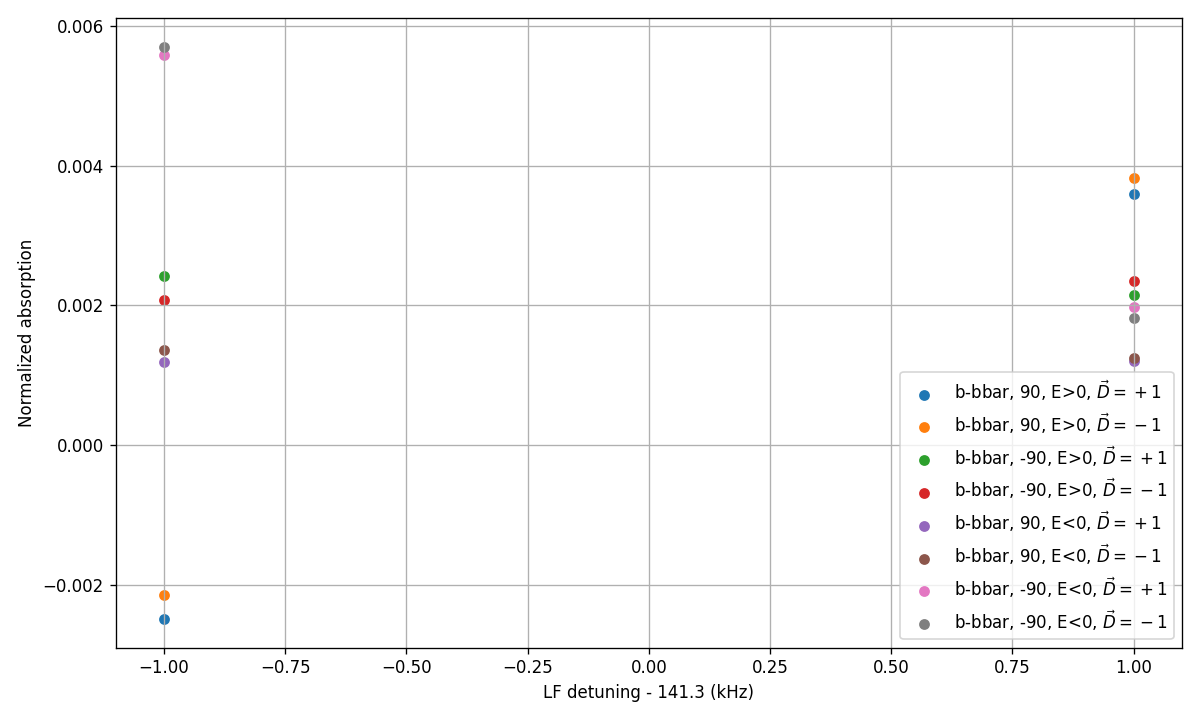

In [384]:
# new sequence
data = {
    # "a-abar, -90, 65": (821886, 821926),
    # "a-abar, 90, 65": (821927, 821967),
    # "b-bbar, 90, 65": (822117, 822157),
    # "b-bbar, -90, 65": (822158, 822198),
    # "b-bbar, -90, 0.5 ms": (822537, 822577),
    # "b-bbar, 90, 0.5 ms": (822578, 822618),
    # "b-bbar, 90, 0.2 ms": (822619, 822659),
    # "b-bbar, -90, 0.2 ms": (822660, 822700),
    # "a-abar, 90, 0.2 ms": (822945, 822985),
    # "a-abar, -90, 0.2 ms": (822986, 823026),
    # "b-bbar, -90, 0.25, 0.5": (823400, 823430),
    # "b-bbar, 90, 0.25, 0.5": (823431, 823448),
    # "a-abar, -90, 0.25, 0.5": (823544, 823554),
    # "a-abar, 90, 0.25, 0.5": (823555, 823565),
    # "a-abar, 90, 0.25, 0.25": (823577, 823587),  # July 7 overnight
    # "a-abar, -90, 0.25, 0.25": (823588, 823598),
    # "b-bbar, -90, 0.25, 0.25": (823599, 823609),
    # "b-bbar, 90, 0.25, 0.25": (823610, 823620),
    # "b-bbar, 90, 0.25, 0.25": (841717, 841727),  # 6 MHz Stark splitting
    # "b-bbar, -90, 0.25, 0.25": (841728, 841738),
    "a-abar, 90, 0.25, 0.25": (841750, 841760),
    "a-abar, -90, 0.25, 0.25": (841739, 841749),
}
data = {
    # "a-abar, 90, E>0, 0.25, 0.25": (823621, 823622),
    # "a-abar, -90, E>0, 0.25, 0.25": (823623, 823624),
    # "a-abar, 90, E<0, 0.25, 0.25": (823625, 823626),
    # "a-abar, -90, E<0, 0.25, 0.25": (823627, 823628),
    # "b-bbar, 90, E>0, 0.25, 0.25": (823629, 823630),
    # "b-bbar, -90, E>0, 0.25, 0.25": (823631, 823632),
    # "b-bbar, 90, E<0, 0.25, 0.25": (823633, 823634),
    # "b-bbar, -90, E<0, 0.25, 0.25": (823635, 823636),
    "b-bbar, 90, E>0": (844701, 844702),
    "b-bbar, -90, E>0": (844703, 844704),
    "b-bbar, 90, E<0": (844705, 844706),
    "b-bbar, -90, E<0": (844707, 844708),
}
plt_background = False

fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    ratios1, ratios2, headers, E_field = get_voltage_ratios(data_list)
    xs = [header["params"]["lf"]["detuning"].to("kHz").magnitude for header in headers]
    ys = (1-ratios1)
    y2s = 1-ratios2
    if E_field[0] is not None:
        for kk in range(2):
            if E_field[0][0] == (kk == 0):
                label_E = label + ", $\\vec{D}=+1$"
            else:
                label_E = label + ", $\\vec{D}=-1$"
            if not plt_background:
                ax.scatter(xs, y2s[:,kk], label=label_E, s = 30)
            else:
                ax.scatter(xs, ys[:,kk], label=label_E, s = 30)

ax.set_xlabel(f"LF detuning - {headers[0]["params"]["lf"]["center_frequency"].to("kHz").magnitude} (kHz)")
ax.set_ylabel("Normalized absorption")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

In [113]:
data = {
    "a-abar, 75 us, 80 us, 90, E>0": (816708, 816709),
    "a-abar, 75 us, 80 us, -90, E>0": (816710, 816711),
    "a-abar, 75 us, 80 us, 90, E<0": (816712, 816713),
    "a-abar, 75 us, 80 us, -90, E<0": (816714, 816715),
    
    # "b-bbar, 75 us, 80 us, 90, E>0": (816716, 816717),
    # "b-bbar, 75 us, 80 us, -90, E>0": (816718, 816719),
    # "b-bbar, 75 us, 80 us, 90, E<0": (816720, 816721),
    # "b-bbar, 75 us, 80 us, -90, E<0": (816722, 816723),
}
max = 816857

total_exp_time = (get_experiment_data(max)[1]["data_info"]["save_epoch_time"] - get_experiment_data(data[list(data)[0]][0])[1]["data_info"]["save_epoch_time"])/3600

fs = {}
f1 = []
f2 = []
Es = []

for kk in data:
    fs[kk] = []

current = data[list(data.keys())[-1]][1]
offset = 0
while current + offset <= max:
    for ll, (label, data_range) in enumerate(data.items()):
        if ll % 2 == 1:
            continue
        data_range_1 = (data_range[0] + offset, data_range[1] + offset)
        data_list = data_identification_to_list(data_range_1)
        ratios_bg, ratios, headers, E_field_1 = get_voltage_ratios(data_list)
        xs = [header["params"]["lf"]["detuning"].to("kHz").magnitude for header in headers]
        ys = (1-ratios)
        data_range_1 = (data_range[0] + offset + 2, data_range[1] + offset + 2)
        data_list = data_identification_to_list(data_range_1)
        ratios_bg, ratios, headers, E_field_2 = get_voltage_ratios(data_list)
        y1s = (1-ratios)
        E_field_1 = list(data)[ll].split(", ")[-1] == "E>0"
        E_field_2 = list(data)[ll+1].split(", ")[-1] == "E>0"
        if E_field_1 != E_field_2:
            raise Exception("Must use data for the same E field")
        
        for kk in range(2):
            y1 = ys[0][kk]
            y2 = y1s[1][kk]
            y3 = y1s[0][kk]
            y4 = ys[1][kk]
            # h1 = abs(ys[0][kk] - y1s[0][kk])
            # h2 = abs(ys[1][kk] - y1s[1][kk])
            if (kk == 0) == E_field_1:
                #f1.append(xs[0] + 2 * h1 / (h1 + h2))
                f1.append((y4 + y1 - y2 - y3) / (y2 - y3 - y4 + y1) + xs[1] - 0.7)
            else:
                #f2.append(xs[0] + 2 * h1 / (h1 + h2))
                f2.append((y4 + y1 - y2 - y3) / (y2 - y3 - y4 + y1) + xs[1] - 0.7)
    offset += 2 * 8

f1 = np.array(f1)
f2 = np.array(f2)

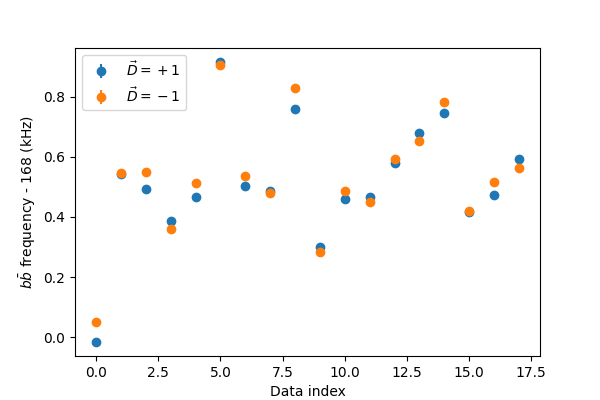

In [114]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.errorbar(np.arange(len(f1)), unumpy.nominal_values(f1), unumpy.std_devs(f1), fmt="o", label="$\\vec{D}=+1$")
ax.errorbar(np.arange(len(f2)), unumpy.nominal_values(f2), unumpy.std_devs(f2), fmt="o", label="$\\vec{D}=-1$")


ax.set_xlabel("Data index")
ax.set_ylabel("$b\\bar{b}$ frequency - 168 (kHz)")
ax.legend()
plt.show()

# June 25, 2024
changes since last analysis:
- taking 4 data points for the ramsey spectroscopy

to do by friday:
- ✔️ is there an algebraic equation that minimizes the uncertainty of the line center using 4 measurements?
- ✔️ time domain trend line -> was temperature drift
- ✔️ expand beam size to check with fluctuations
      - check current beam size w/ beam profiler -> beam profiler not working
      - 2 mm diameter for 3 x 4 mm cyrstal
- ✔️ look for trend in the normalized absorption w/ the same parameters in LF ramsey
- take less averages (AWG fix)
- improve duty cycle
- maximize RF rabi frequency with RF resonance tuning
      

32
total experiment time = 0.42575696779621974 h
f_plus = 0.3572 +/- 0.0616 kHz
f_minus = 0.3619 +/- 0.0541 kHz
f_plus - f_minus = -0.0047 +/- 0.0114 kHz


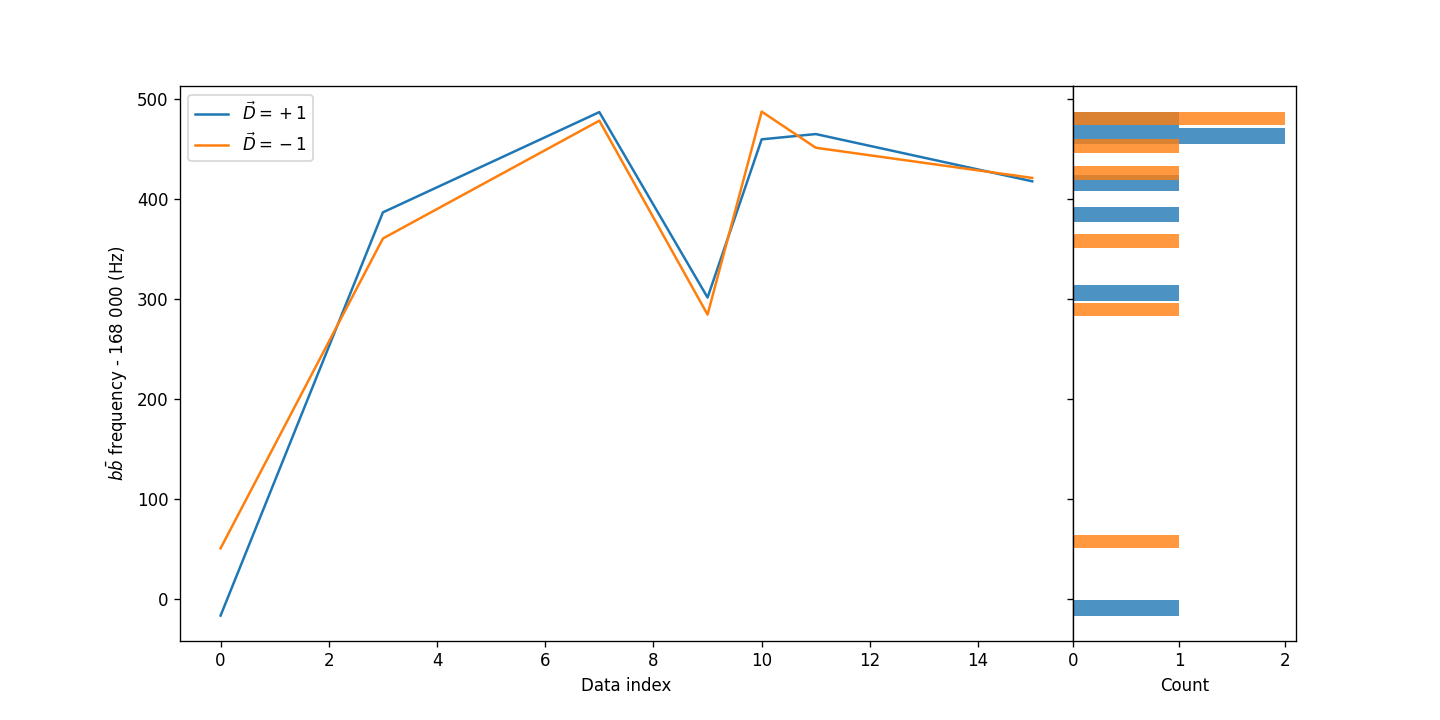

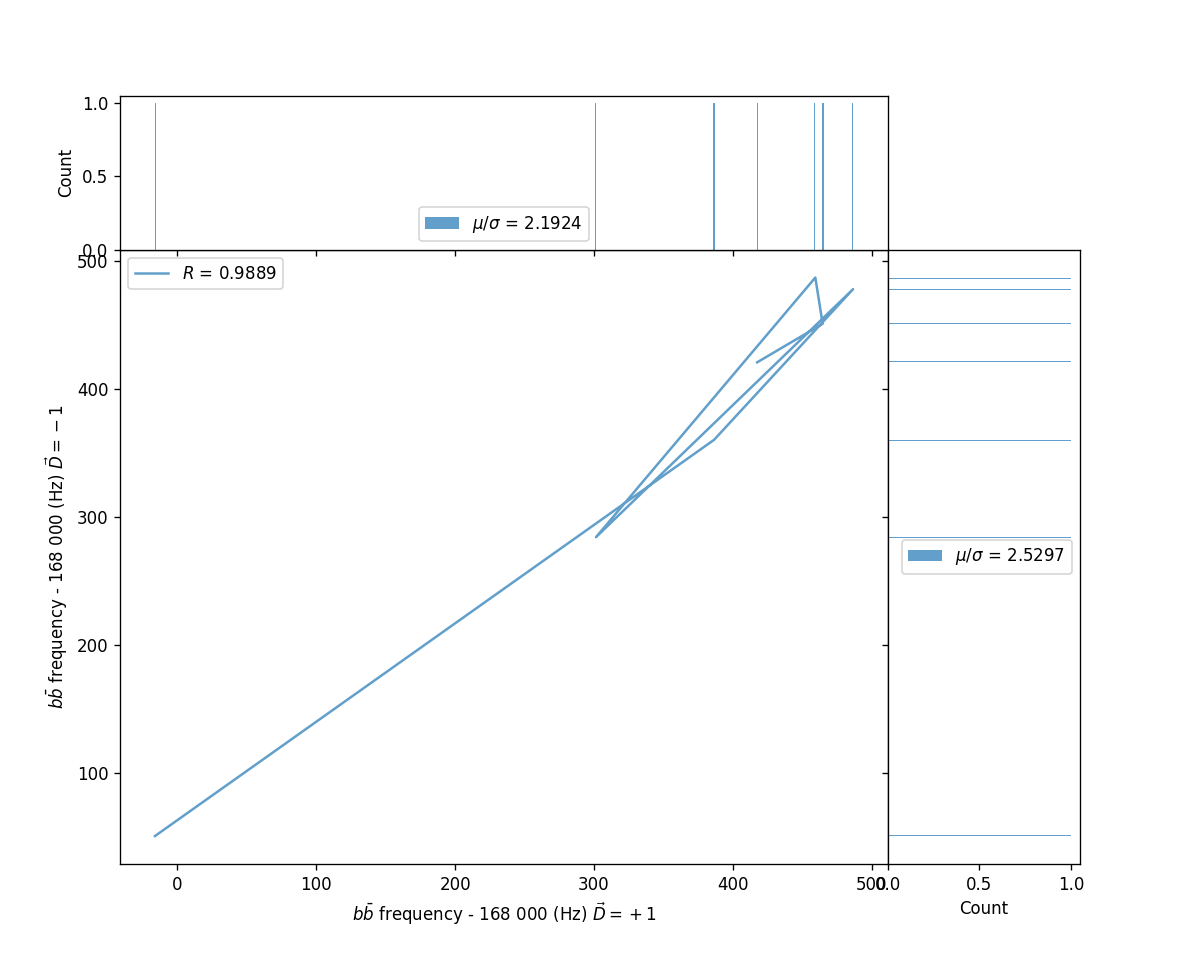

In [115]:
def mask_array(array):
    return array  # all array
    return array[::2]  # all even indices
    return array[1::2]  # all odd indices


xs1 = mask_array(np.arange(len(f1)))
ys1 = mask_array(unumpy.nominal_values(f1))
ys1_err = mask_array(unumpy.std_devs(f1))

xs2 = mask_array(np.arange(len(f2)))
ys2 = mask_array(unumpy.nominal_values(f2))
ys2_err = mask_array(unumpy.std_devs(f2))

f_diff = f1 - f2
xs3 = mask_array(np.arange(len(f_diff)))
ys3 = mask_array(unumpy.nominal_values(f_diff))
ys3_err = mask_array(unumpy.std_devs(f_diff))

delete_mask = np.ones(len(xs1), dtype=bool)
for kk in range(len(xs1)):
    if abs(ys1[kk] + 0.5) > 1 or abs(ys2[kk] + 0.5) > 1:
        delete_mask[kk] = False
xs1 = xs1[delete_mask]
ys1 = ys1[delete_mask]
ys1_err = ys1_err[delete_mask]
xs2 = xs2[delete_mask]
ys2 = ys2[delete_mask]
ys2_err = ys2_err[delete_mask]
xs3 = xs3[delete_mask]
ys3 = ys3[delete_mask]
ys3_err = ys3_err[delete_mask]

n_bins = int(np.sqrt(len(f1))) * 8
print(n_bins)
bins_alpha = 0.8

fig, axs = plt.subplots(1, 2, figsize = (12, 6), dpi = 120, sharey='row', gridspec_kw={'width_ratios': [4, 1]})
axs[0].plot(xs1, ys1*1000., label="$\\vec{D}=+1$")
_ = axs[1].hist(ys1*1000., bins=n_bins, orientation='horizontal', alpha=bins_alpha)
# axs[0].plot([np.min(xs1), np.max(xs1)], [np.average(ys1), np.average(ys1)])

axs[0].plot(xs2, ys2*1000., label="$\\vec{D}=-1$")
_ = axs[1].hist(ys2*1000., bins=n_bins, orientation='horizontal', alpha=bins_alpha)

axs[0].set_xlabel("Data index")
axs[1].set_xlabel("Count")
axs[0].set_ylabel("$b\\bar{b}$ frequency - 168 000 (Hz)")
axs[0].legend()
# axs[0].set_ylim([200, 600])

print(f"total experiment time = {total_exp_time} h")
print(f"f_plus = {np.average(ys1):.4f} +/- {np.std(ys1) / np.sqrt(len(ys1)):.4f} kHz")
print(f"f_minus = {np.average(ys2):.4f} +/- {np.std(ys2) / np.sqrt(len(ys2)):.4f} kHz")
print(f"f_plus - f_minus = {np.average(ys3):.4f} +/- {np.std(ys3) / np.sqrt(len(ys3)):.4f} kHz")
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

fig = plt.figure(figsize = (10, 8), dpi = 120)
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.0, hspace=0.0)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)
xs = ys1*1000
ys = ys2*1000
bins = 500



colors = plt.cm.jet(np.linspace(0, 1, len(ys)))
for color, x, y in zip(colors, xs, ys):  # change this to heat map or something
    ax.plot(x, y, color = color, alpha=0.7)#, label = f"$R$ = {pearsonr(xs, ys).statistic:.4f}")
    
ax.plot(xs, ys, alpha=0.7, label = f"$R$ = {pearsonr(xs, ys).statistic:.4f}")
ax_histx.hist(xs, bins=bins, alpha=0.7, label=f"$\\mu/\\sigma$ = {np.average(xs)/np.std(xs):.4f}")
ax_histy.hist(ys, bins=bins, alpha=0.7, orientation='horizontal', label=f"$\\mu/\\sigma$ = {np.average(ys)/np.std(ys):.4f}")

ax.set_xlabel("$b\\bar{b}$ frequency - 168 000 (Hz) $\\vec{D}=+1$")
ax.set_ylabel("$b\\bar{b}$ frequency - 168 000 (Hz) $\\vec{D}=-1$")
ax_histx.set_ylabel("Count")
ax_histy.set_xlabel("Count")
ax.legend()
ax_histx.legend()
ax_histy.legend()
plt.show()



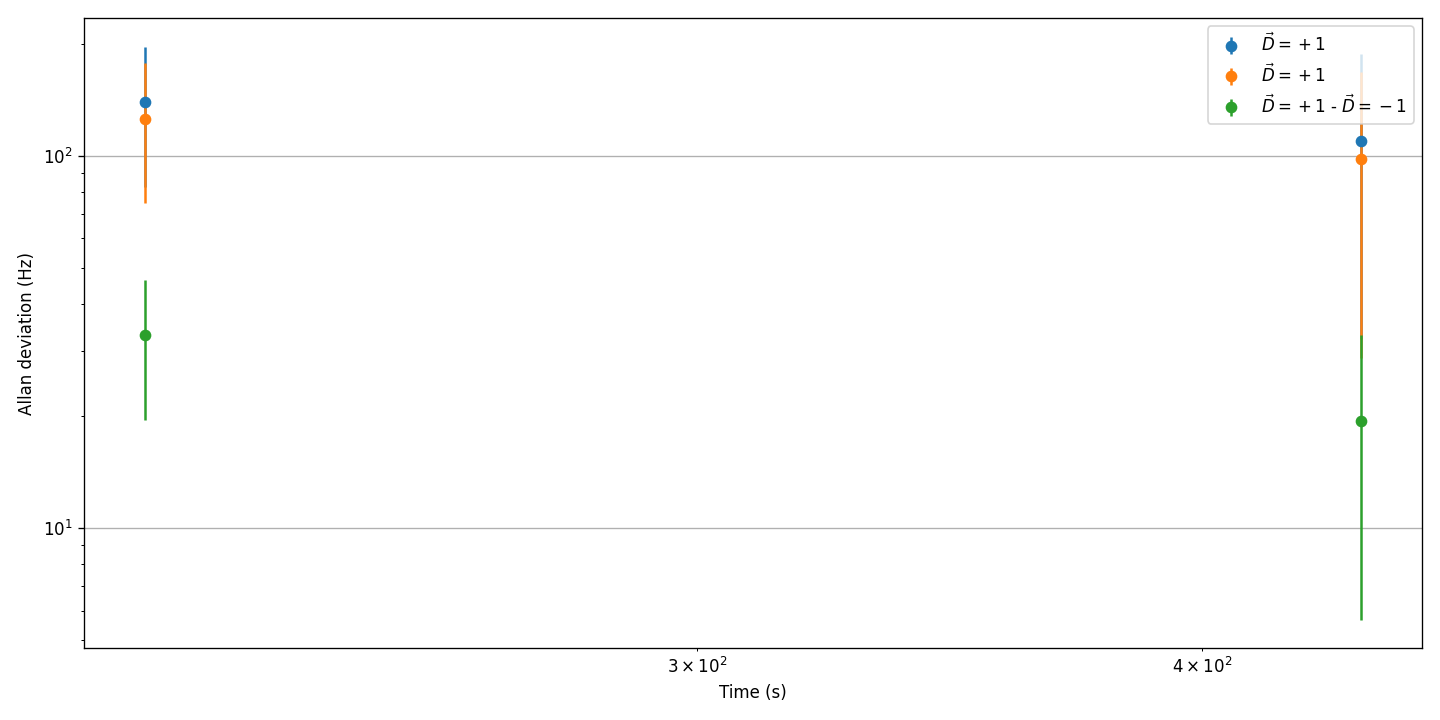

In [116]:
taus1 = np.logspace(0, np.log10(len(ys1) // 3), 200)
real_taus1, allan1, allan_err1, _ = allantools.adev(ys1 * 1000, data_type="freq", taus=taus1)
real_taus1 *= total_exp_time * 3600 / len(ys1)

taus2 = np.logspace(0, np.log10(len(ys2) // 3), 200)
real_taus2, allan2, allan_err2, _ = allantools.adev(ys2 * 1000, data_type="freq", taus=taus2)
real_taus2 *= total_exp_time * 3600 / len(ys2)

taus3 = np.logspace(0, np.log10(len(ys1) // 3), 200)
real_taus3, allan3, allan_err3, _ = allantools.adev(ys3 * 1000, data_type="freq", taus=taus3)
real_taus3 *= total_exp_time * 3600 / len(ys1)

fig, ax = plt.subplots(figsize = (12, 6), dpi = 120)
ax.errorbar(real_taus1, allan1, allan_err1, fmt="o", label="$\\vec{D}=+1$")
ax.errorbar(real_taus2, allan2, allan_err2, fmt="o", label="$\\vec{D}=+1$")
ax.errorbar(real_taus3, allan3, allan_err3, fmt="o", label="$\\vec{D}=+1$ - $\\vec{D}=-1$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Allan deviation (Hz)")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

## Fluctuations in LF Ramsey (1 data point)

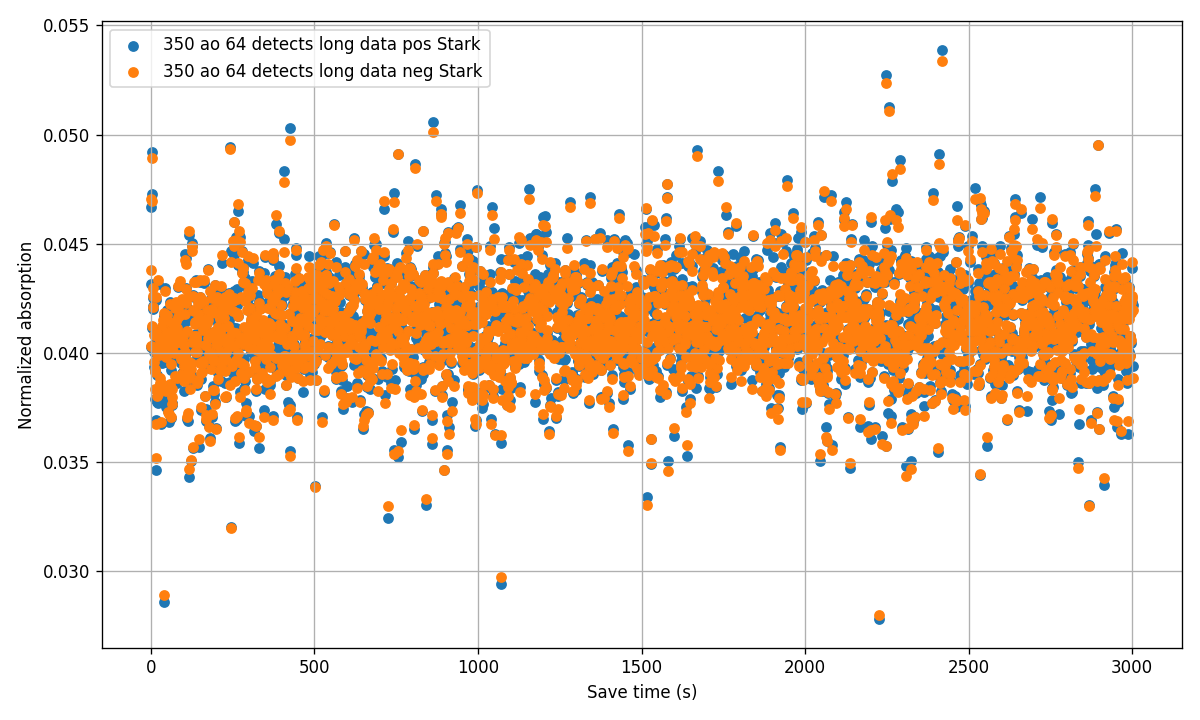

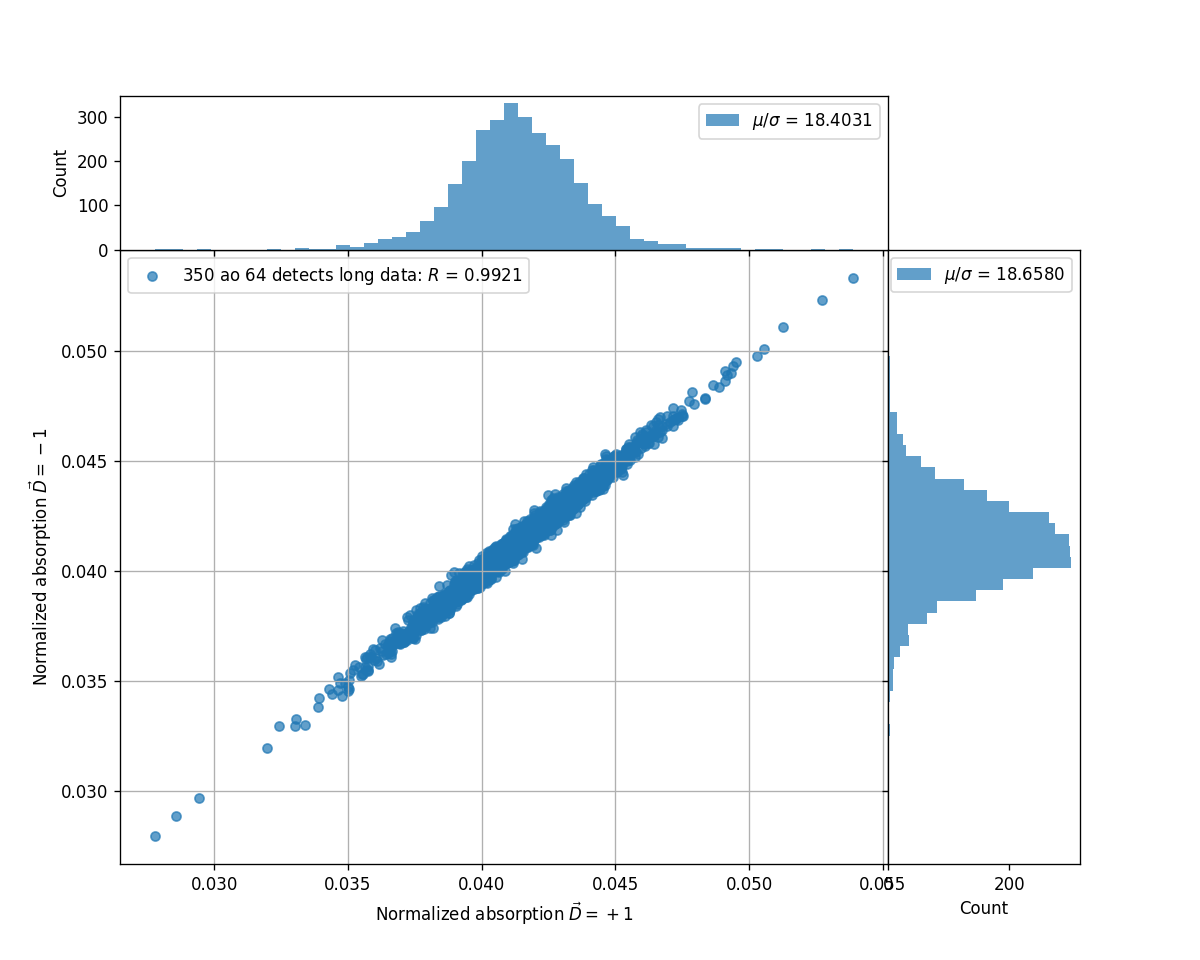

In [193]:
data = {
    # "original": (588222, 588418),
    # "sync 0.713(0.01)s": (592518, 592702),
    # "no sync": (592704, 592916),
    # "sync 0.713(0.001)s": (592923, 593092),
    # "no sync 2": (593094, 593306),
    # "no sync 3": (593328, 593553),


    # COMPARISON:    
    # "350 ao 32 detects": (594308, 594529),
    # "350 ao 64 detects": (594531, 594752),
    # "350 ao 256 detects": (594754, 594972),
    # "400 ao 64 detects": (594974, 595192),
    # "425 ao 64 detects": (595417, 595638),
    # "450 ao 64 detects": (595194, 595415),
    # "400 ao 64 detects rep": (595640, 595863),
    # "350 ao 64 detects rep": (595865, 596088),


    "350 ao 64 detects long data": (596089, 599091),
    # "350 ao 64 detects long data (SAME BUT IGNORE FIRST 1000)": (597089, 599091),
}
fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    ratios, headers, E_field = get_voltage_ratios(data_list)
    # xs = [header["data_info"]["save_epoch_time"]-headers[0]["data_info"]["save_epoch_time"] for header in headers]
    xs = [i for i in range(len(headers))]
    ys = (1-ratios)
    if E_field[0] is not None:
        ax.scatter(xs, ys[:,0], label=label + " pos Stark", s = 30)
        ax.scatter(xs, ys[:,1], label=label + " neg Stark", s = 30)
        # ax.scatter(xs, ys[:,0]-ys[:,1], label=label + "$\\vec{D}=+1$ - $\\vec{D}=-1$", s = 30)

ax.set_xlabel(f"Save time (s)")
ax.set_ylabel("Normalized absorption")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

fig = plt.figure(figsize = (10, 8), dpi = 120)
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.0, hspace=0.0)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    ratios, headers, E_field = get_voltage_ratios(data_list)
    xsys = (1-ratios)
    xs = xsys[:, 0]
    ys = xsys[:, 1]
    bins = 50
    ax.scatter(xs, ys, s = 30, alpha=0.7, label = f"{label}: $R$ = {pearsonr(xs, ys).statistic:.4f}")
    ax_histx.hist(xs, bins=bins, alpha=0.7, label=f"$\\mu/\\sigma$ = {np.average(xs)/np.std(xs):.4f}")
    ax_histy.hist(ys, bins=bins, alpha=0.7, orientation='horizontal', label=f"$\\mu/\\sigma$ = {np.average(ys)/np.std(ys):.4f}")

ax.set_xlabel("Normalized absorption $\\vec{D}=+1$")
ax.set_ylabel("Normalized absorption $\\vec{D}=-1$")
ax_histx.set_ylabel("Count")
ax_histy.set_xlabel("Count")
ax.grid()
ax.legend()
ax_histx.legend()
ax_histy.legend()
plt.show()



0.9945744020212515

## Fluctuations in Hole burning

0.004199764272051945
0.006971096344848625
0.003937793905072617
0.0034490014055966814


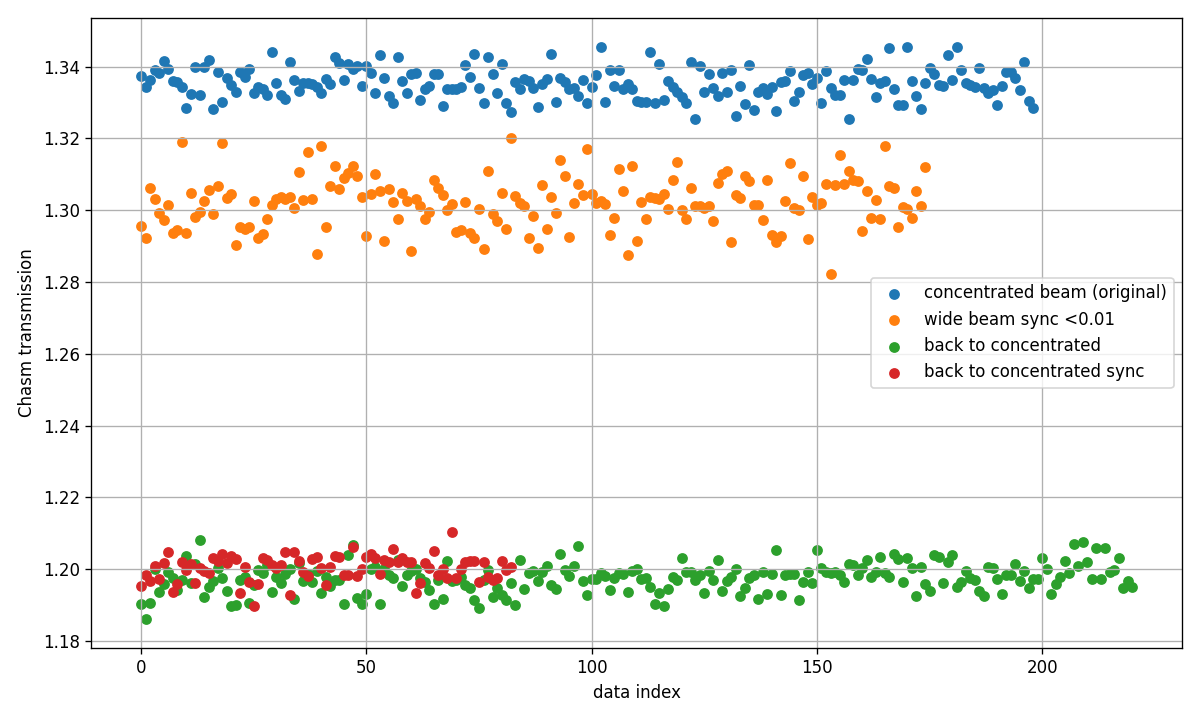

In [159]:
data = {
    # "chasm -> immediate detect": (588421, 588753)

    # chasm -> immediate detect -> wait -> detect
    "concentrated beam (original)": (589333, 589531),
    # "3 decimal sync": (590121, 590239),
    # "wider beam diameter": (590407, 591294),
    # "back to concentrated beam 2": (591568, 591693),
    # "wide beam 2": (591916, 592043),
    # "wide beam sync <0.1": (592090, 592150),
    "wide beam sync <0.01": (592271, 592445),
    "back to concentrated": (593659, 593879),
    "back to concentrated sync": (593891, 593973),
}
fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    ys = []
    xs = []
    for kk, data_num in enumerate(data_list):
        transmissions_avg, monitors_avg, headers = averaged_data_from_number(data_num)
        # xs.append(headers["data_info"]["save_epoch_time"])
        xs.append(kk)
        ys.append((transmissions_avg["antihole"][0]/monitors_avg["antihole"][0]))
    print(np.std(ys))
    ax.scatter(xs, ys, s = 30, label=label)

ax.set_xlabel(f"data index")
ax.set_ylabel("Chasm transmission")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

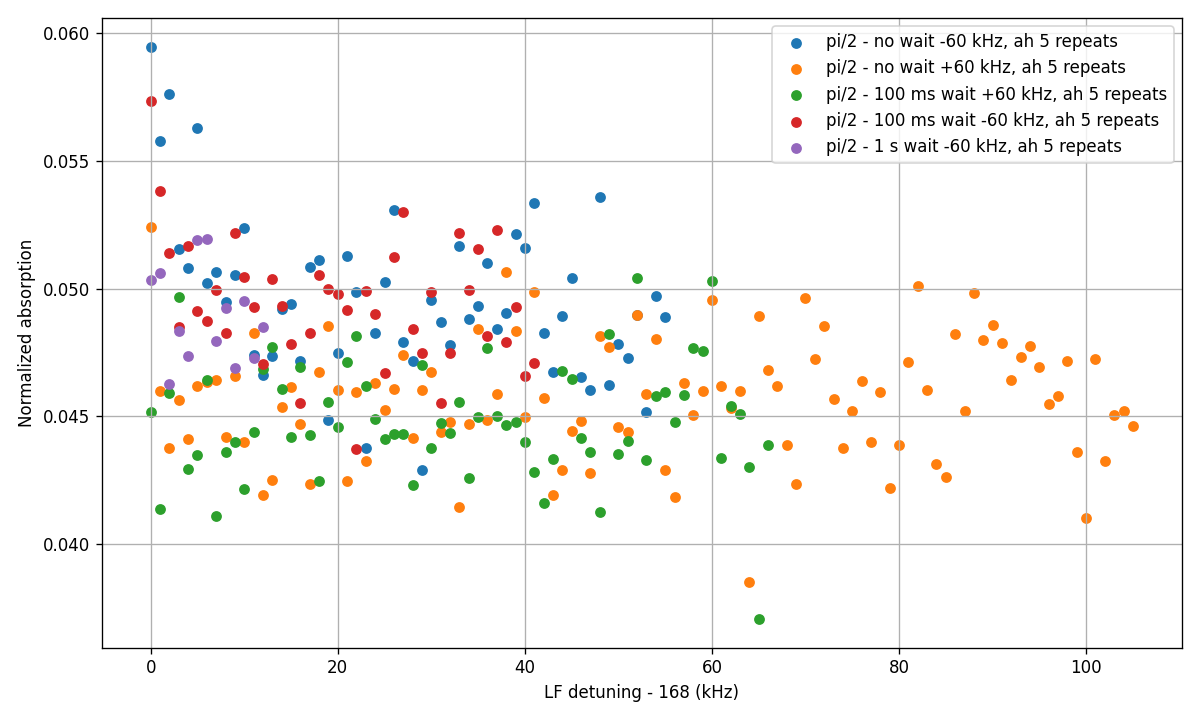

In [274]:
data = {
    # "pi/2 - no wait -60 kHz": (609490, 609544),
    # "pi/2 - no wait +60 kHz": (609545, 609591),
    # "pi/2 - no wait no rf": (609603, 609647),
    # "rf_b +60 kHz": (609649, 609707),
    # "rf_b -60 kHz": (609709, 609741),
    # "pi/2 - no wait +60 kHz, ah 20 repeats": (609743, 609826),
    # "pi/2 - no wait -60 kHz, ah 20 repeats": (609828, 609930),
    "pi/2 - no wait -60 kHz, ah 5 repeats": (609932, 609987),
    "pi/2 - no wait +60 kHz, ah 5 repeats": (609989, 610094),
    "pi/2 - 100 ms wait +60 kHz, ah 5 repeats": (610097, 610163),
    "pi/2 - 100 ms wait -60 kHz, ah 5 repeats": (610176, 610217),
    "pi/2 - 1 s wait -60 kHz, ah 5 repeats": (610249, 610261),
}

fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    ratios, headers, E_field = get_voltage_ratios(data_list)
    xs = [header["data_info"]["data_number"] for header in headers]
    xs = np.array(xs) - xs[0]
    ys = (1-ratios)[:, 0]
    ax.scatter(xs, ys, label=label, s = 30)

ax.set_xlabel(f"LF detuning - {headers[0]["params"]["lf"]["center_frequency"].to("kHz").magnitude} (kHz)")
ax.set_ylabel("Normalized absorption")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()